### 🧠 OVERALL ML PIPELINE (HIGH-LEVEL MAP)

In [1]:
print("""
Clean Dataset
   ↓
Feature Selection & Grouping      (separate features for Cost vs CO₂)
   ↓
Train / Validation / Test Split   (explicit split, stratify if needed)
   ↓
Preprocessing Pipelines           (numeric scaling, categorical encoding)
   ↓
Baseline Model Training           (RandomForest for Cost, XGB for CO₂)
   ↓
Hyperparameter Tuning             (GridSearchCV / RandomizedSearchCV)
   ↓
Evaluation                       (RMSE, MAE, R² on validation + test sets)
   ↓
Material Ranking Generation       (Cost ascending, CO₂ ascending)
   ↓
Model + Preprocessor Saving       (pickle .pkl for UI)
   ↓
Inference Pipeline for UI         (load model + pipeline, generate predictions)
""")


Clean Dataset
   ↓
Feature Selection & Grouping      (separate features for Cost vs CO₂)
   ↓
Train / Validation / Test Split   (explicit split, stratify if needed)
   ↓
Preprocessing Pipelines           (numeric scaling, categorical encoding)
   ↓
Baseline Model Training           (RandomForest for Cost, XGB for CO₂)
   ↓
Hyperparameter Tuning             (GridSearchCV / RandomizedSearchCV)
   ↓
Evaluation                       (RMSE, MAE, R² on validation + test sets)
   ↓
Material Ranking Generation       (Cost ascending, CO₂ ascending)
   ↓
Model + Preprocessor Saving       (pickle .pkl for UI)
   ↓
Inference Pipeline for UI         (load model + pipeline, generate predictions)



### Import Libraries and Global Configuration

In [2]:
# ======================================================
# STEP 1: IMPORTS
# ======================================================

import numpy as np
import pandas as pd

# Visualization (EDA / validation only)
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor

# Persistence
import joblib
from pathlib import Path

In [3]:
pd.set_option('display.max_rows', None)        # show all rows
pd.set_option('display.max_columns', None)     # show all columns

pd.set_option('display.width', None)           # auto-adjust width
pd.set_option('display.max_colwidth', None)    # show full column content

### Define Datapaths

In [4]:
# ======================================================
# STEP 2: PATH CONFIG
# ======================================================

DATA_PATH = Path(r"..\..\data\processed\final_ecopack_dataset_fe.csv")
MODEL_DIR = Path(r"..\models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Data path:", DATA_PATH.resolve())
print("✓ Model directory:", MODEL_DIR.resolve())

✓ Data path: E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\data\processed\final_ecopack_dataset_fe.csv
✓ Model directory: E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\ml\models


### Machine Learning Dataset Preparation  

### LOAD DATA

In [5]:
# ======================================================
# STEP 3: LOAD DATA
# ======================================================

df = pd.read_csv(DATA_PATH)

print("Dataset loaded")
print("Shape:", df.shape)
df.head()

Dataset loaded
Shape: (14999, 25)


,Category_item,Weight_kg,Volumetric_Weight_kg,Fragility,Moisture_Sens,Shipping_Mode,Distance_km,Packaging_Used,Cost_USD,CO2_Emission_kg_item,Material_ID,Material_Name,Category_material,Density_kg_m3,Tensile_Strength_MPa,Cost_per_kg,CO2_Emission_kg_material,Biodegradable,co2_impact_index,cost_efficiency_index,environmental_impact_score,material_suitability_score,sustainability_score,sustainability_rating,Item_Volume_m3
0,Clothing,0.82,1.41,5,False,Air,1893,Kraft Paper Mailer,1.56,6.673,550.0,Laminated Kraft Paper,Paper,868,59.17,1.52,1.026,Yes,49.96,8.88,26.85,26.22,0.396871,D,0.007056
1,Electronics,0.29,0.00,9,True,Air,2141,Mushroom Pkg (Mycelium),1.92,1.552,601.0,Mushroom Pkg (Mycelium),Bio-based,95,12.00,3.20,0.180,Yes,78.00,5.37,7.96,3.72,0.809548,D,0.000000
2,Furniture,12.26,38.06,6,False,Road,1491,Wood Crate,16.42,28.374,405.0,Recycled Pine Wood Crate,Wood,484,30.47,1.74,0.290,Yes,45.51,33.00,26.71,11.50,1.482591,B,0.190320
3,Furniture,11.56,38.27,5,False,Road,530,Wood Crate,16.31,10.142,405.0,Recycled Pine Wood Crate,Wood,484,30.47,1.74,0.290,Yes,58.46,27.73,20.36,13.44,1.634381,B,0.191360
4,Clothing,0.25,0.08,1,False,Air,1587,Kraft Paper Mailer,0.30,0.992,550.0,Laminated Kraft Paper,Paper,868,59.17,1.52,1.026,Yes,81.47,1.08,9.94,78.90,0.130382,E,0.000396


### DATA SANITY CHECK

In [6]:
# ======================================================
# STEP 4: BASIC SANITY CHECKS
# ======================================================

df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Category_item               14999 non-null  object 
 1   Weight_kg                   14999 non-null  float64
 2   Volumetric_Weight_kg        14999 non-null  float64
 3   Fragility                   14999 non-null  int64  
 4   Moisture_Sens               14999 non-null  bool   
 5   Shipping_Mode               14999 non-null  object 
 6   Distance_km                 14999 non-null  int64  
 7   Packaging_Used              14999 non-null  object 
 8   Cost_USD                    14999 non-null  float64
 9   CO2_Emission_kg_item        14999 non-null  float64
 10  Material_ID                 14999 non-null  float64
 11  Material_Name               14999 non-null  object 
 12  Category_material           14999 non-null  object 
 13  Density_kg_m3               149

,Category_item,Weight_kg,Volumetric_Weight_kg,Fragility,Moisture_Sens,Shipping_Mode,Distance_km,Packaging_Used,Cost_USD,CO2_Emission_kg_item,Material_ID,Material_Name,Category_material,Density_kg_m3,Tensile_Strength_MPa,Cost_per_kg,CO2_Emission_kg_material,Biodegradable,co2_impact_index,cost_efficiency_index,environmental_impact_score,material_suitability_score,sustainability_score,sustainability_rating,Item_Volume_m3
count,14999,14999.000000,14999.000000,14999.000000,14999,14999,14999.000000,14999,14999.000000,14999.000000,14999.000000,14999,14999,14999.000000,14999.000000,14999.00000,14999.000000,14999,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04,14999,14999.000000
unique,5,NaN,NaN,NaN,2,2,NaN,10,NaN,NaN,NaN,10,5,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,5,NaN
top,Electronics,NaN,NaN,NaN,True,Air,NaN,Mushroom Pkg (Mycelium),NaN,NaN,NaN,Mushroom Pkg (Mycelium),Bio-based,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,D,NaN
freq,4667,NaN,NaN,NaN,8079,7703,NaN,5821,NaN,NaN,NaN,5821,5821,NaN,NaN,NaN,NaN,14745,NaN,NaN,NaN,NaN,NaN,3000,NaN
mean,NaN,9.093512,26.652157,6.331822,NaN,NaN,1516.990799,NaN,12.755699,24.488254,535.345623,NaN,NaN,474.230549,33.241657,2.40294,0.649852,NaN,61.727663,25.132372,17.760995,18.472370,2.892677e+02,NaN,0.133260
std,NaN,16.701961,76.334885,2.739958,NaN,NaN,853.148023,NaN,30.376056,67.792178,113.839698,NaN,NaN,388.871809,22.321876,0.81148,0.590508,NaN,24.017591,26.819134,12.411235,19.583799,3.507784e+04,NaN,0.381675
min,NaN,0.100000,0.000000,1.000000,NaN,NaN,50.000000,NaN,0.260000,0.003000,34.000000,NaN,NaN,27.000000,0.520000,1.03000,0.180000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000
25%,NaN,0.350000,0.100000,4.000000,NaN,NaN,779.000000,NaN,1.290000,0.871500,550.000000,NaN,NaN,95.000000,12.000000,1.59000,0.180000,NaN,45.225000,5.960000,7.890000,3.720000,4.597895e-01,NaN,0.000475
50%,NaN,1.350000,1.170000,6.000000,NaN,NaN,1515.000000,NaN,2.140000,4.445000,601.000000,NaN,NaN,380.000000,30.470000,1.95000,0.290000,NaN,60.600000,13.250000,16.220000,11.500000,1.124543e+00,NaN,0.005850
75%,NaN,13.145000,5.780000,9.000000,NaN,NaN,2253.000000,NaN,8.520000,14.752000,601.000000,NaN,NaN,868.000000,59.170000,3.20000,1.026000,NaN,83.020000,33.050000,25.420000,31.480000,2.178703e+00,NaN,0.028910


## 🟦 CATEGORICAL COLUMNS — QUICK VIEW

### `Category_item`
- **Type:** Item category  
- **Unique values:** 5  
- **Most common:** Electronics  
- **Use:** Context for packaging & material choice

### `Moisture_Sens`
- **Type:** Boolean (`True / False`)  
- **Meaning:** Needs moisture protection  
- **Bias:** Slightly more `True`  
- **Use:** Drives barrier material selection

### `Shipping_Mode`
- **Type:** Categorical  
- **Values:** 2 → `Air`, `Road`  
- **Impact:** Strong effect on CO₂

### `Packaging_Used`
- **Type:** Categorical  
- **Unique types:** 10  
- **Most common:** Mycelium packaging  
- **Use:** Historical / benchmark reference

### `Material_Name`
- **Type:** Categorical  
- **Unique materials:** 10  
- **Use:** Candidate set for recommendations

### `Category_material`
- **Type:** Material class  
- **Unique categories:** 5  
- **Top:** Bio-based  
- **Use:** Sustainability grouping

### `Biodegradable`
- **Type:** Boolean (`Yes / No`)  
- **Distribution:** Mostly `Yes`  
- **Use:** Sustainability filter (not strong predictor)

### `sustainability_rating`
- **Type:** Ordinal label  
- **Values:** 5 (`A–E`)  
- **Use:** Human-readable output only

---

## 🟨 `Fragility` (IMPORTANT)
- **Type:** Ordinal numeric  
- **Range:** 1 → 10  
- **Median:** ~6  
- **Meaning:** Handling sensitivity  
- **Impact:** Higher → stronger / cushioned packaging needed

In [7]:
# Categorical columns + Fragility
cat_cols = ["Category_item", "Moisture_Sens", "Shipping_Mode", 
            "Packaging_Used", "Material_Name", "Category_material", 
            "Biodegradable", "sustainability_rating"]
ordinal_cols = ["Fragility"]

print("\n🟦 Categorical Columns & Unique Values\n")
for col in cat_cols:
    uniques = df[col].value_counts()
    print(f"{col}:")
    print(uniques.to_frame(name="Count"))
    print("-"*40)

print("\n🟨 Ordinal Column - Fragility\n")
frag_counts = df["Fragility"].value_counts().sort_index()
print(frag_counts.to_frame(name="Count"))


🟦 Categorical Columns & Unique Values

Category_item:
               Count
Category_item       
Electronics     4667
Furniture       3499
Clothing        3392
Beauty          2295
Home Decor      1146
----------------------------------------
Moisture_Sens:
               Count
Moisture_Sens       
True            8079
False           6920
----------------------------------------
Shipping_Mode:
               Count
Shipping_Mode       
Air             7703
Road            7296
----------------------------------------
Packaging_Used:
                         Count
Packaging_Used                
Mushroom Pkg (Mycelium)   5821
Kraft Paper Mailer        3284
Wood Crate                2293
Honeycomb Paper           1712
PLA Bioplastic            1141
Corrugated Cardboard       427
Styrofoam (EPS)             96
Bubble Wrap (LDPE)          85
Recycled PET Box            73
Cornstarch Foam             67
----------------------------------------
Material_Name:
                             Coun

### Define Targets and Features

##### We are building two independent regression systems:
```
🎯 Cost Prediction Model → Random Forest Regressor

🌍 CO₂ Footprint Model → XGBoost Regressor
```

## 🚫 FIRST — HARD EXCLUSIONS
### 📌 Reason:
#### Targets, labels, surrogate keys, or post-model derived scores → leakage.
```
Cost_USD
CO2_Emission_kg_item

Material_Name
Material_ID

co2_impact_index
cost_efficiency_index
environmental_impact_score
material_suitability_score
sustainability_score
sustainability_rating
```

### Split Features and Targets

In [8]:
# 🎯 COST PREDICTION (RandomForestRegressor)

# Predict packaging cost based on material usage & protection needs
TARGET_COST = "Cost_USD"

FEATURES_COST = [
    # Item geometry & weight
    "Weight_kg",
    "Volumetric_Weight_kg",
    "Item_Volume_m3",

    # Item handling
    "Fragility",
    "Moisture_Sens",

    # Material properties
    "Category_material",
    "Density_kg_m3",
    "Tensile_Strength_MPa",
    "Cost_per_kg",
    "Biodegradable",

    # Context
    "Category_item"
]

# -----------------------------------------------------------------
# 🌍 CO₂ PREDICTION (XGBRegressor)

# Predict carbon footprint of packaging + logistics
TARGET_CO2 = "CO2_Emission_kg_item"

FEATURES_CO2 = [
    # Shipment geometry & load
    "Weight_kg",
    "Volumetric_Weight_kg",
    "Item_Volume_m3",

    # Logistics
    "Distance_km",
    "Shipping_Mode",

    # Material emissions
    "Density_kg_m3",
    "CO2_Emission_kg_material",
    "Biodegradable",

    # Context
    "Category_item",
    "Category_material"
]

In [9]:
joblib.dump(FEATURES_COST, MODEL_DIR / "features_cost.pkl")
joblib.dump(FEATURES_CO2, MODEL_DIR / "features_co2.pkl")

['..\\models\\features_co2.pkl']

## Exploratory Data Analysis

In [10]:
numeric_features = [
    "Distance_km",
    "Weight_kg",
    "Volumetric_Weight_kg",
    "Item_Volume_m3",
    "Density_kg_m3",
    "Tensile_Strength_MPa",
    "Cost_per_kg",
    "CO2_Emission_kg_material"
]
categorical_features = [
    "Category_item",
    "Category_material",
    "Shipping_Mode",
    "Biodegradable",
    "Packaging_Used"
]

### Numeric Features vs Targets (Scatter plots)

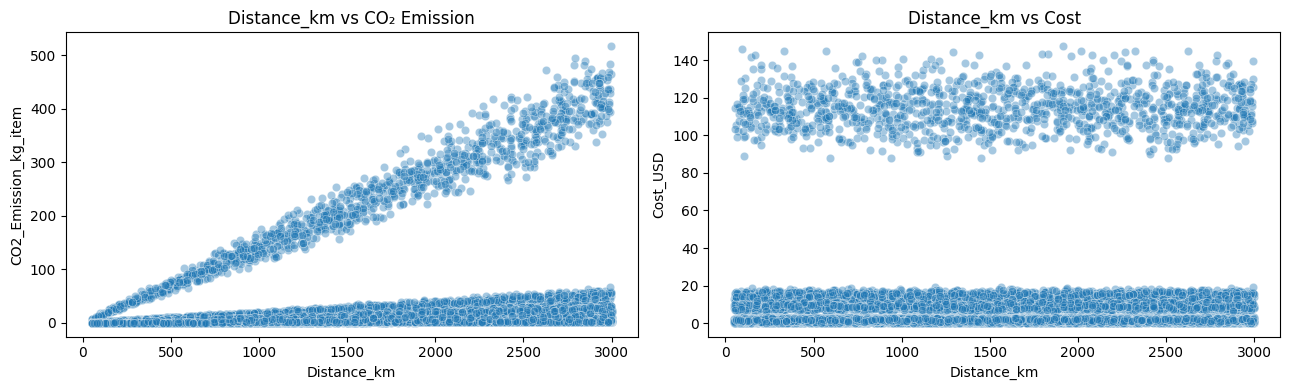

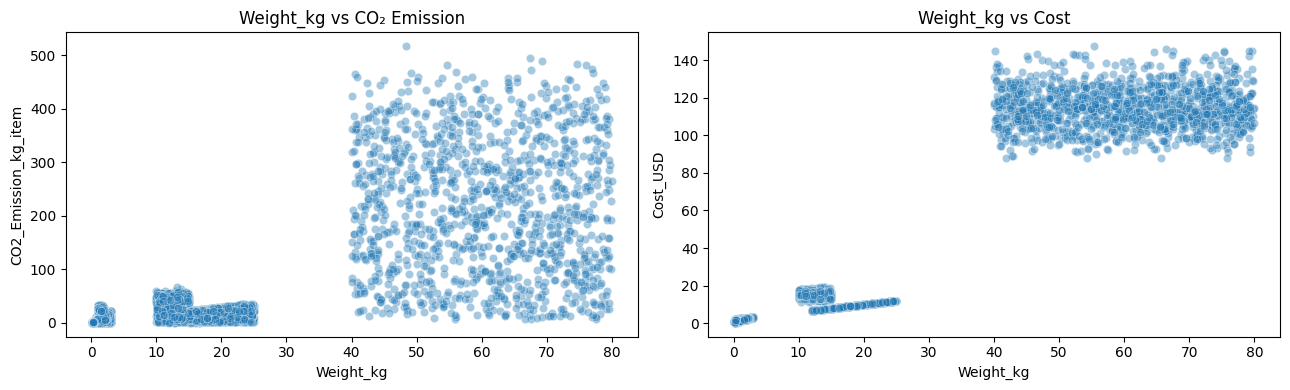

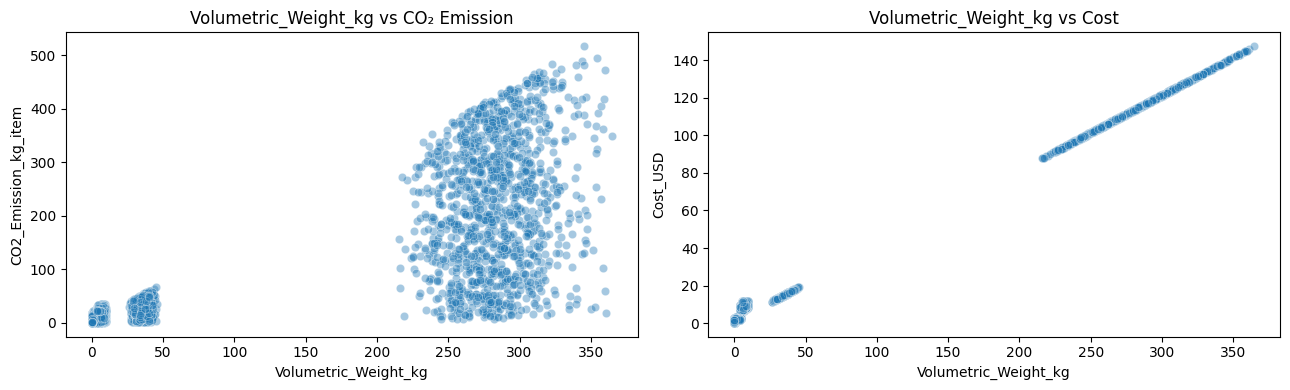

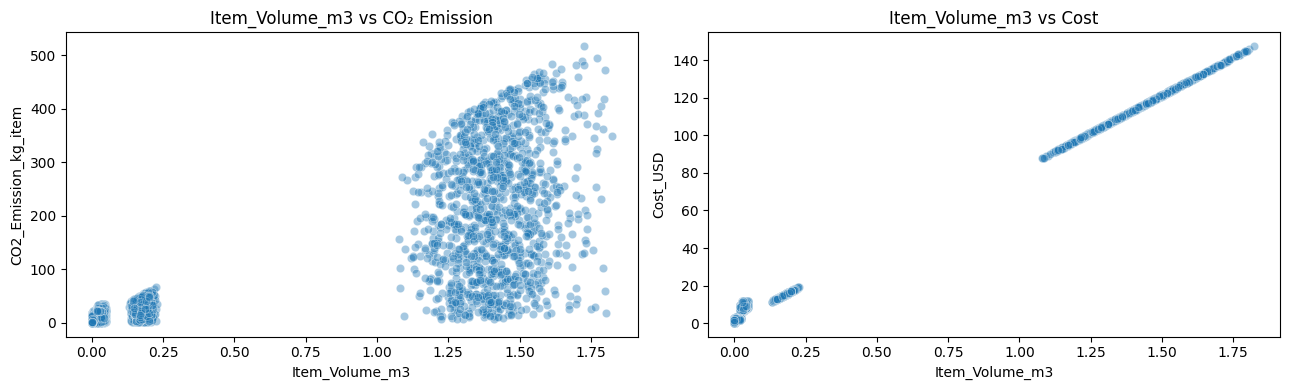

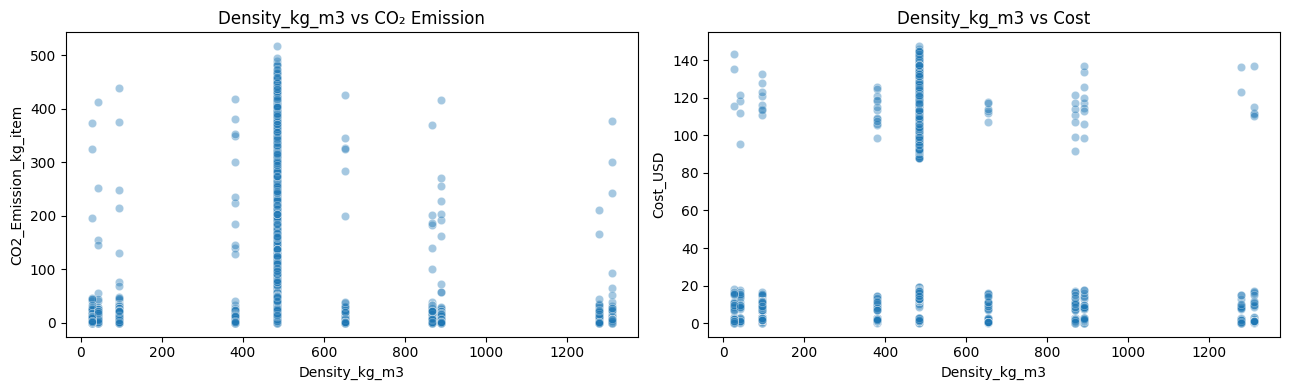

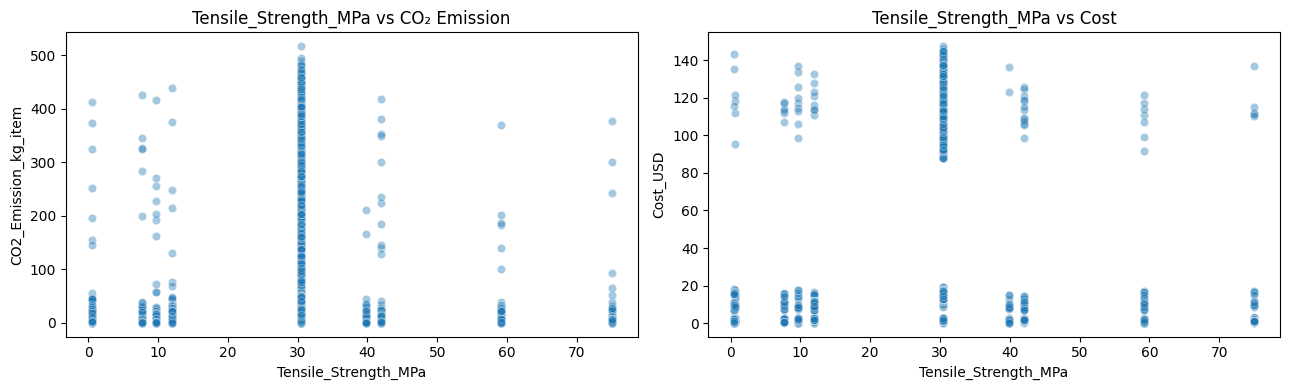

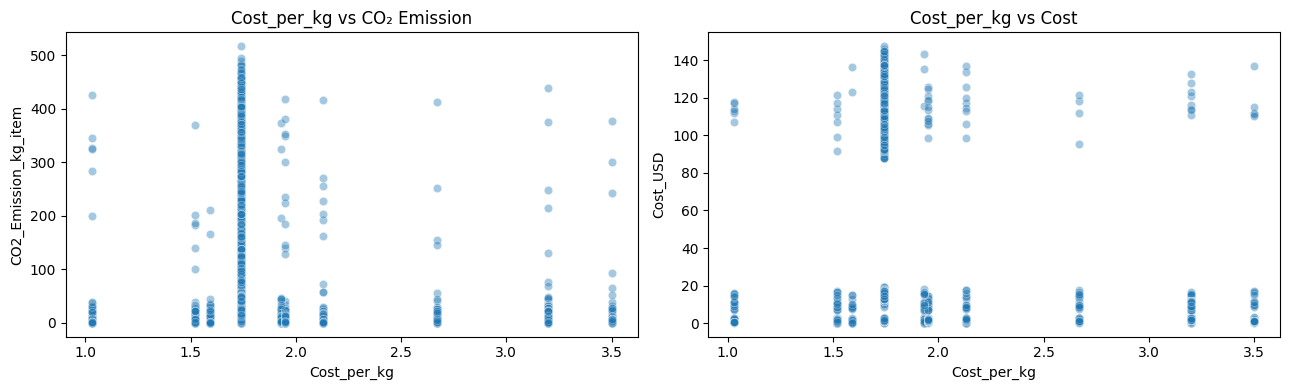

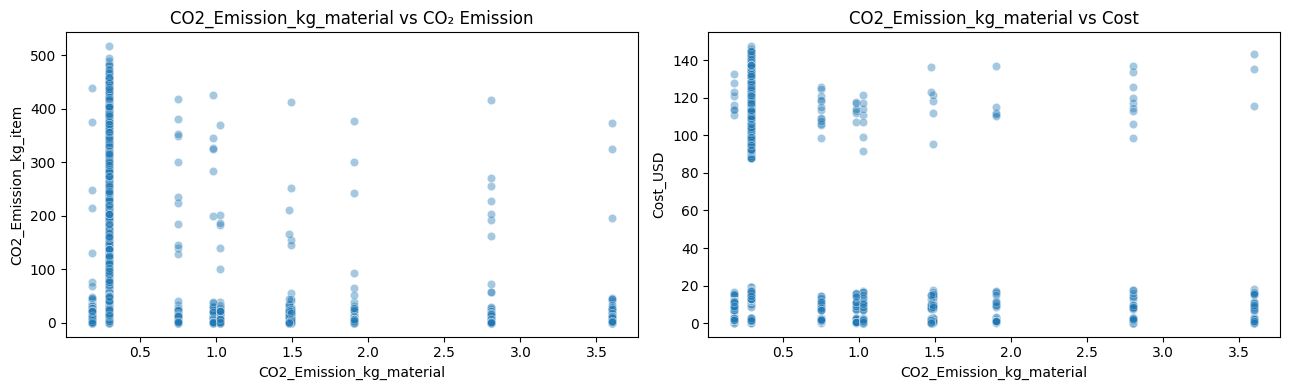

In [11]:
for feature in numeric_features:
    fig, ax = plt.subplots(1, 2, figsize=(13,4))

    # CO2
    sns.scatterplot(
        data=df,
        x=feature,
        y=TARGET_CO2,
        alpha=0.4,
        ax=ax[0]
    )
    ax[0].set_title(f"{feature} vs CO₂ Emission")

    # Cost
    sns.scatterplot(
        data=df,
        x=feature,
        y=TARGET_COST,
        alpha=0.4,
        ax=ax[1]
    )
    ax[1].set_title(f"{feature} vs Cost")

    plt.tight_layout()
    plt.show()

### Categorical Features vs Targets (Aggregated Bars Plots)

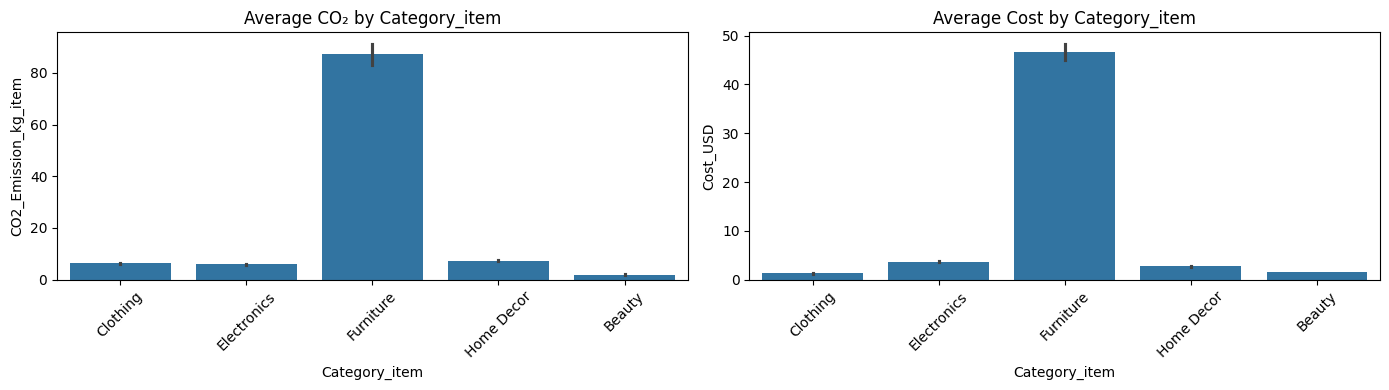

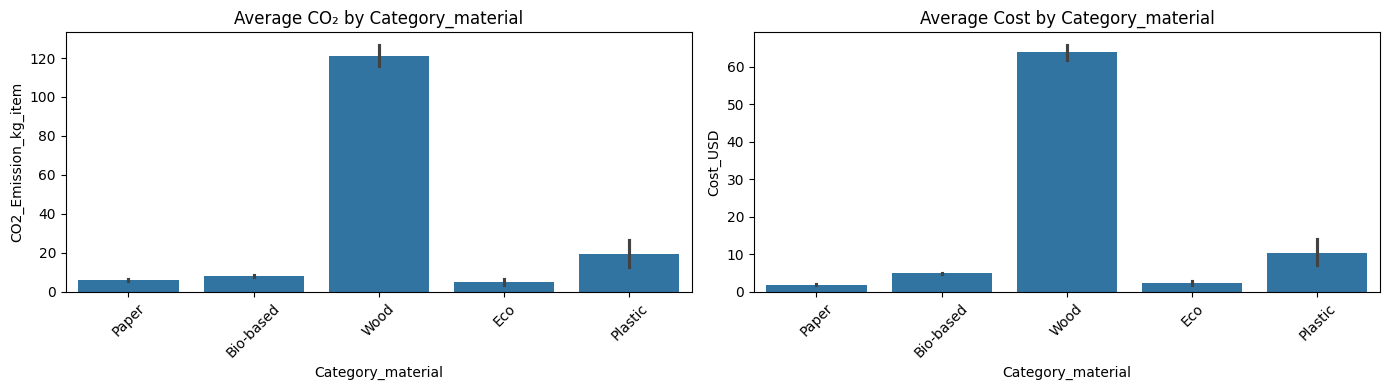

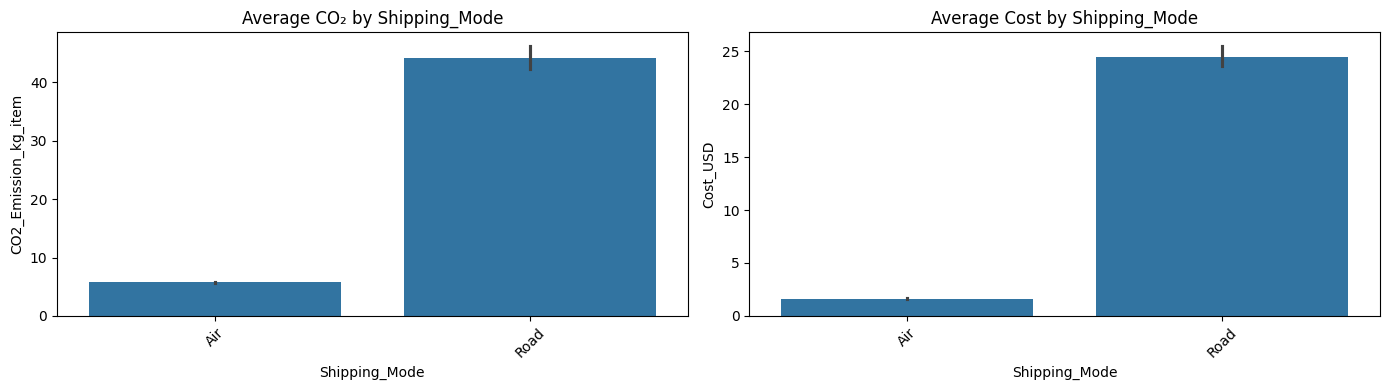

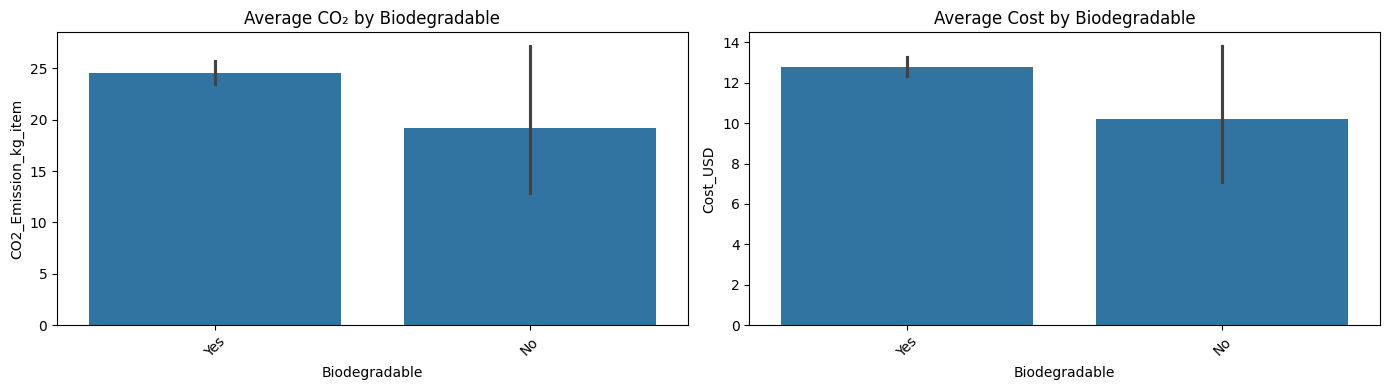

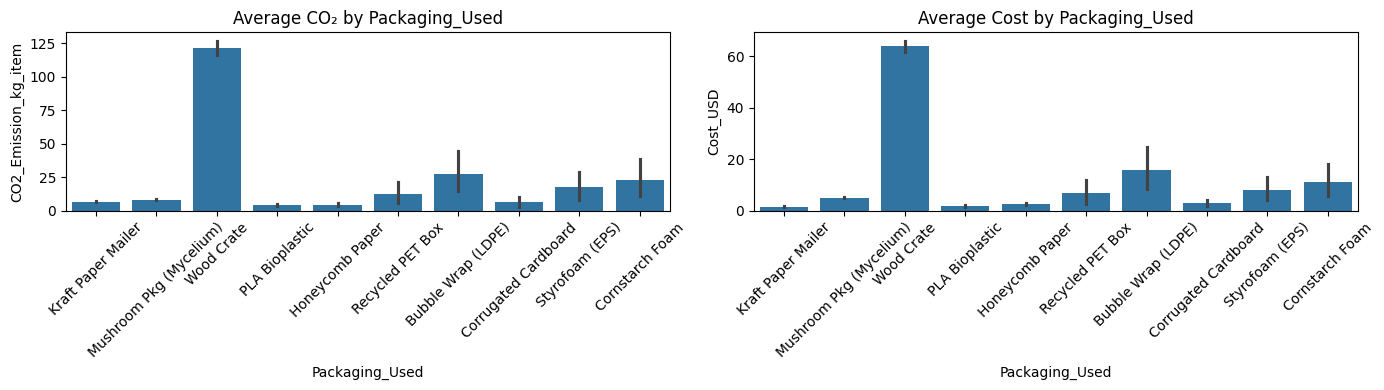

In [12]:
for feature in categorical_features:
    fig, ax = plt.subplots(1, 2, figsize=(14,4))

    # CO2
    sns.barplot(
        data=df,
        x=feature,
        y=TARGET_CO2,
        estimator=np.mean,
        ax=ax[0]
    )
    ax[0].set_title(f"Average CO₂ by {feature}")
    ax[0].tick_params(axis='x', rotation=45)

    # Cost
    sns.barplot(
        data=df,
        x=feature,
        y=TARGET_COST,
        estimator=np.mean,
        ax=ax[1]
    )
    ax[1].set_title(f"Average Cost by {feature}")
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

### Correlation Heatmap (Numeric Only)

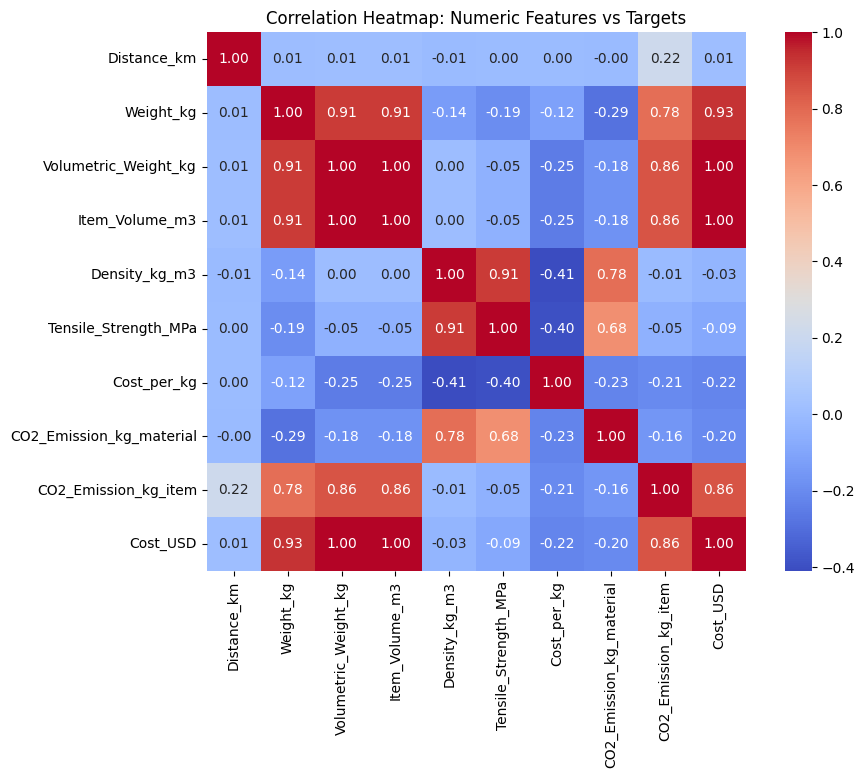

In [13]:
corr_cols = numeric_features + [TARGET_CO2, TARGET_COST]

plt.figure(figsize=(10,7))
corr = df[corr_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)

plt.title("Correlation Heatmap: Numeric Features vs Targets")
plt.show()

### Preprocessing Pipelines

#### 1. Numerical features (need scaling)
#### 2. Categorical features (need encoding)

### Preprocessing pipeline

In [14]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(
            handle_unknown="ignore",
            sparse=True
        ))
    ]
)

            User Input
                ↓
        Feature Preprocessor
                ↓
     ┌────────────┴────────────┐
     ↓                         ↓
 Cost Model               CO₂ Model
     ↓                         ↓
 Predicted Cost        Predicted CO₂
     └────────────┬────────────┘
                  ↓
        Sustainability Scoring
                  ↓
        Top-K Recommendations

### 🔹 COST MODEL PREPROCESSOR (RandomForest)

In [15]:
NUMERIC_FEATURES_COST = [
    "Weight_kg",
    "Volumetric_Weight_kg",
    "Item_Volume_m3",
    "Fragility",
    "Density_kg_m3",
    "Tensile_Strength_MPa",
    "Cost_per_kg"
]

CATEGORICAL_FEATURES_COST = [
    "Category_item",
    "Category_material",
    "Biodegradable"
]

In [16]:
preprocessor_cost = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES_COST),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES_COST)
    ],
    remainder="drop"
)

### 🔹 CO₂ MODEL PREPROCESSOR (XGBoost)

In [17]:
NUMERIC_FEATURES_CO2 = [
    "Weight_kg",
    "Volumetric_Weight_kg",
    "Item_Volume_m3",
    "Distance_km",
    "Density_kg_m3",
    "CO2_Emission_kg_material"
]

CATEGORICAL_FEATURES_CO2 = [
    "Shipping_Mode",
    "Category_item",
    "Category_material",
    "Biodegradable"
]

In [18]:
preprocessor_co2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES_CO2),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES_CO2)
    ],
    remainder="drop"
)

### 🔹 IMPORTANT: BOOLEAN SAFETY

In [19]:
df["Moisture_Sens"] = df["Moisture_Sens"].astype(int)
df["Biodegradable"] = df["Biodegradable"].map({"Yes": 1, "No": 0})

## 1. Cost Model

### Train Test Split 

In [20]:
# Target
y_cost = df[TARGET_COST]

# Features
X_cost = df[FEATURES_COST]

print("X_cost shape:", X_cost.shape)
print("y_cost shape:", y_cost.shape)

X_cost shape: (14999, 11)
y_cost shape: (14999,)


In [21]:
# ======================================================
# STEP 9: TRAIN-TEST SPLIT
# ======================================================

X_cost_train, X_cost_temp, y_cost_train, y_cost_temp = train_test_split(
    X_cost,
    y_cost,
    test_size=0.4,
    random_state=42
)

X_cost_val, X_cost_test, y_cost_val, y_cost_test = train_test_split(
    X_cost_temp,
    y_cost_temp,
    test_size=0.5,
    random_state=42
)

print("Train:", X_cost_train.shape)
print("Val  :", X_cost_val.shape)
print("Test :", X_cost_test.shape)

Train: (8999, 11)
Val  : (3000, 11)
Test : (3000, 11)


### Model 1 :-> Random Forest – Cost

In [22]:
rf_cost = Pipeline(
    steps=[
        ("preprocessor", preprocessor_cost),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

### BASELINE TRAINING (Validation Check)

In [23]:
rf_cost.fit(X_cost_train, y_cost_train)

rf_cost_val_preds = rf_cost.predict(X_cost_val)

print("RF COST VAL MAE:", mean_absolute_error(y_cost_val, rf_cost_val_preds))
print("RF COST VAL R2 :", r2_score(y_cost_val, rf_cost_val_preds))

E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\ecopackvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RF COST VAL MAE: 0.01897235000000068
RF COST VAL R2 : 0.9999947938565888


### HYPERPARAMETER TUNING : GridSearchCV (Random Forest – Cost)

In [24]:
rf_cost_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 3, 5]
}

rf_cost_grid = GridSearchCV(
    estimator=rf_cost,
    param_grid=rf_cost_param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

rf_cost_grid.fit(X_cost_train, y_cost_train)

best_rf_cost = rf_cost_grid.best_estimator_

print("Best RF Cost Params:")
print(rf_cost_grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\ecopackvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best RF Cost Params:
{'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 400}


### Evaluate Best RF on Test Set

In [25]:
rf_cost_test_preds = best_rf_cost.predict(X_cost_test)

print("RF COST TEST MAE:", mean_absolute_error(y_cost_test, rf_cost_test_preds))
print("RF COST TEST R2 :", r2_score(y_cost_test, rf_cost_test_preds))

RF COST TEST MAE: 0.015794483333334226
RF COST TEST R2 : 0.9999958814031794


### Save Cost Model for Deployment

In [26]:
final_cost_model = best_rf_cost

joblib.dump(final_cost_model, MODEL_DIR / "cost_model.pkl")

print("✔ Final COST model saved at:", MODEL_DIR / "cost_model.pkl")

✔ Final COST model saved at: ..\models\cost_model.pkl


## 2. CO2 Model

### Train Test Split 

In [27]:
# Target
y_co2 = df[TARGET_CO2]

# Features
X_co2 = df[FEATURES_CO2]

print("X_co2 shape:", X_co2.shape)
print("y_co2 shape:", y_co2.shape)

X_co2 shape: (14999, 10)
y_co2 shape: (14999,)


In [28]:
# ======================================================
# STEP 9: TRAIN-TEST SPLIT
# ======================================================

X_co2_train, X_co2_temp, y_co2_train, y_co2_temp = train_test_split(
    X_co2,
    y_co2,
    test_size=0.4,
    random_state=42
)

X_co2_val, X_co2_test, y_co2_val, y_co2_test = train_test_split(
    X_co2_temp,
    y_co2_temp,
    test_size=0.5,
    random_state=42
)

print("Train:", X_co2_train.shape)
print("Val  :", X_co2_val.shape)
print("Test :", X_co2_test.shape)

Train: (8999, 10)
Val  : (3000, 10)
Test : (3000, 10)


### Model 2 :-> XGBoost – CO2

In [29]:
xgb_co2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_co2),
        ("model", XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

### BASELINE TRAINING (VALIDATION)

In [30]:
xgb_co2.fit(X_co2_train, y_co2_train)

xgb_val_preds = xgb_co2.predict(X_co2_val)

print("XGB CO₂ VAL MAE:", mean_absolute_error(y_co2_val, xgb_val_preds))
print("XGB CO₂ VAL R2 :", r2_score(y_co2_val, xgb_val_preds))

E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\ecopackvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


XGB CO₂ VAL MAE: 0.5383477837125022
XGB CO₂ VAL R2 : 0.9992876817536062


### HYPERPARAMETER TUNING : GridSearchCV (XGBoost – CO2)

In [31]:
xgb_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_co2,
    param_grid=xgb_param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_co2_train, y_co2_train)

best_xgb_co2 = xgb_grid.best_estimator_

print("Best XGB CO₂ Params:")
print(xgb_grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


E:\NEW_FOLDER\Projects_Java_Python\AI-Powered Sustainable Packaging Recommendation System\ecopackvenv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best XGB CO₂ Params:
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 8, 'model__n_estimators': 500, 'model__subsample': 0.8}


### Evaluate Best XGB on Test Set

In [32]:
xgb_test_preds = best_xgb_co2.predict(X_co2_test)

print("XGB CO₂ TEST MAE:", mean_absolute_error(y_co2_test, xgb_test_preds))
print("XGB CO₂ TEST R2 :", r2_score(y_co2_test, xgb_test_preds))

XGB CO₂ TEST MAE: 0.40049671437027456
XGB CO₂ TEST R2 : 0.9979667542278836


### Save CO2 Model for Deployment

In [33]:
final_co2_model = best_xgb_co2

joblib.dump(final_co2_model, MODEL_DIR / "co2_model.pkl")

print("✔ Final CO₂ model saved at:", MODEL_DIR / "co2_model.pkl")

✔ Final CO₂ model saved at: ..\models\co2_model.pkl
